In [7]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import regionprops, label

PATH FILE

In [13]:
base_path = "."              # folder tempat ipynb berada
class_folders = ["ANORGANIK", "ORGANIK"]

BACKGROUND REMOVAL

In [14]:
def remove_background(image):
    h, w = image.shape[:2]
    rect = (10, 10, w-20, h-20)

    mask = np.zeros((h, w), np.uint8)
    bgModel = np.zeros((1, 65), np.float64)
    fgModel = np.zeros((1, 65), np.float64)

    cv2.grabCut(image, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)

    # 0 & 2 = background, 1 & 3 = foreground
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # apply mask ke image → hasil remove background
    result = image * mask2[:, :, np.newaxis]

    return result, mask2    # ← kembalikan 2 nilai

PREPROCESSING


=== KELAS: ANORGANIK ===


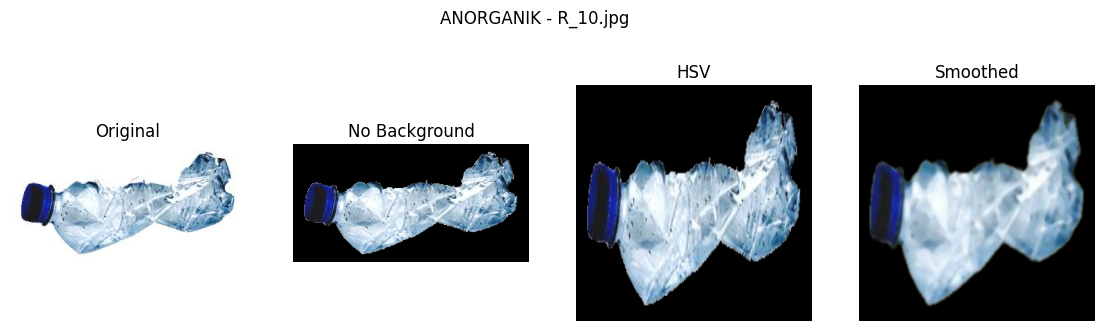

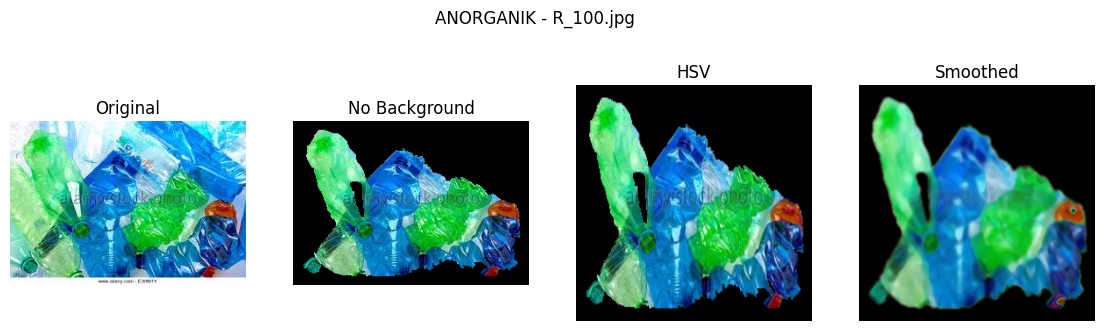

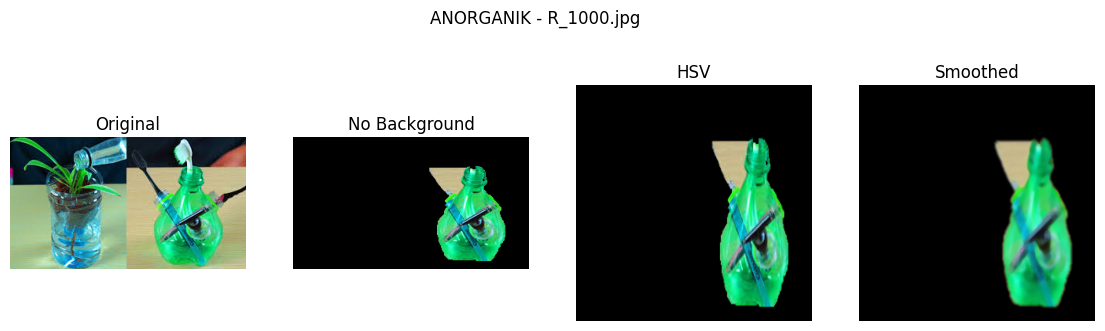


=== KELAS: ORGANIK ===


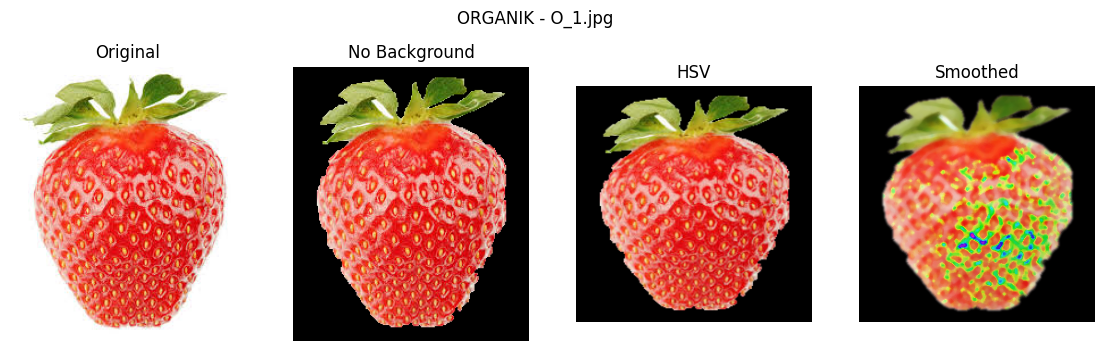

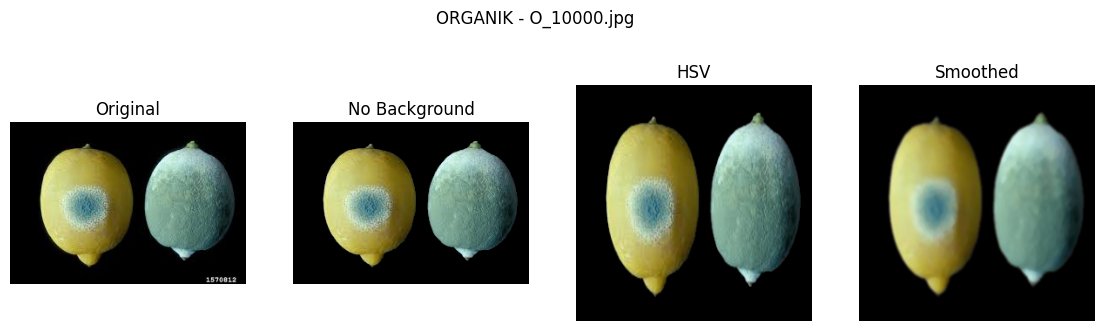

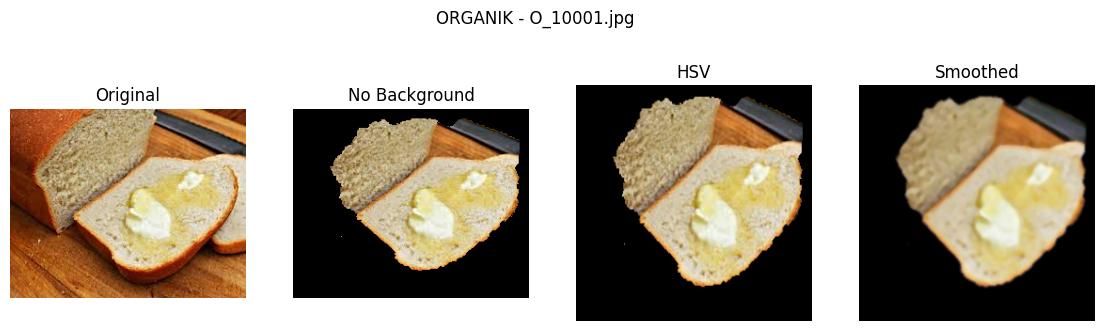

In [16]:
for cls in class_folders:
    folder_path = os.path.join(base_path, cls)
    print(f"\n=== KELAS: {cls} ===")

    # ambil hanya 3 gambar pertama untuk ditampilkan (biar tidak panjang)
    sample_images = os.listdir(folder_path)[:3]

    for img_name in sample_images:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        # 1. Remove background
        no_bg, mask = remove_background(img)

        # 2. Resize
        resized = cv2.resize(no_bg, (256, 256))

        # 3. Convert RGB → HSV
        hsv = cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)

        # 4. Smoothing
        gaussian = cv2.GaussianBlur(hsv, (5, 5), 0)
        median = cv2.medianBlur(gaussian, 5)

        # ---- TAMPILKAN HASIL ----
        plt.figure(figsize=(14, 4))
        plt.suptitle(f"{cls} - {img_name}")

        plt.subplot(1, 4, 1)
        plt.title("Original")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.title("No Background")
        plt.imshow(cv2.cvtColor(no_bg, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.title("HSV")
        plt.imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB))
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.title("Smoothed")
        plt.imshow(cv2.cvtColor(median, cv2.COLOR_HSV2RGB))
        plt.axis('off')

        plt.show()

FUNGSI EKSTRAKSI FITUR

In [17]:
def extract_features(img, mask, label_class):
    # Resize dan HSV
    img = cv2.resize(img, (256, 256))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 1. Fitur Warna: Mean & Std HSV
    mean_hsv = np.mean(hsv, axis=(0,1))
    std_hsv = np.std(hsv, axis=(0,1))

    # Histogram warna (16 bin setiap channel)
    hist_h = cv2.calcHist([hsv], [0], None, [16], [0,180]).flatten()
    hist_s = cv2.calcHist([hsv], [1], None, [16], [0,256]).flatten()
    hist_v = cv2.calcHist([hsv], [2], None, [16], [0,256]).flatten()
    hist_all = np.concatenate([hist_h, hist_s, hist_v])

    # 2. Fitur Tekstur GLCM
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    contrast = graycoprops(glcm, "contrast")[0,0]
    correlation = graycoprops(glcm, "correlation")[0,0]
    energy = graycoprops(glcm, "energy")[0,0]
    homogeneity = graycoprops(glcm, "homogeneity")[0,0]

    # 3. Fitur Bentuk (Shape)
    region = label(mask)
    props = regionprops(region)

    if len(props) > 0:
        area = props[0].area
        perimeter = props[0].perimeter if props[0].perimeter > 0 else 1
        convex_area = props[0].convex_area

        area_ratio = area / (256*256)
        solidity = area / convex_area
        circularity = (4 * np.pi * area) / (perimeter**2)
    else:
        area_ratio = solidity = circularity = 0

    # Gabungkan semua fitur
    feature_vector = np.concatenate([
        mean_hsv, std_hsv, hist_all,
        [contrast, correlation, energy, homogeneity],
        [area_ratio, solidity, circularity]
    ])

    return feature_vector

EKSTRAKSI FITUR UNTUK SEMUA GAMBAR

In [18]:
data = []
labels = []

for cls in class_folders:
    print(f"\nEkstraksi fitur untuk kelas: {cls}")

    images = os.listdir(cls)
    for img_name in images:
        img_path = os.path.join(cls, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # Remove background
        removed, mask = remove_background(img)

        # Extract features
        feat = extract_features(removed, mask, cls)

        data.append(feat)
        labels.append(cls)

# Konversi ke DataFrame
df_features = pd.DataFrame(data)
df_features["label"] = labels

print("\n=== Contoh Data Fitur ===")
df_features.head()


Ekstraksi fitur untuk kelas: ANORGANIK

Ekstraksi fitur untuk kelas: ORGANIK

=== Contoh Data Fitur ===


,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,label
0,42.433838,27.463440,78.906754,51.078253,44.543179,101.776465,38597.0,37.0,97.0,15.0,...,4222.0,5671.0,276.585263,0.983634,0.580693,0.634665,0.275864,0.748055,0.344352,ANORGANIK
1,40.192734,90.314148,78.118393,46.519834,106.143418,91.159278,36318.0,199.0,2.0,3.0,...,1812.0,1291.0,234.094240,0.969126,0.539267,0.587849,0.340378,0.884567,0.338456,ANORGANIK
2,23.004776,43.351562,61.334229,35.344428,69.998284,88.129761,42323.0,926.0,4729.0,414.0,...,981.0,753.0,231.122488,0.979038,0.634319,0.737237,0.012283,0.877863,0.569692,ANORGANIK
3,41.279785,87.578674,94.208267,53.657401,105.536558,97.259886,38683.0,223.0,47.0,4957.0,...,3648.0,678.0,399.302237,0.960716,0.474061,0.642891,0.380814,0.668103,0.130763,ANORGANIK
4,6.884521,15.507004,14.612442,26.844352,51.719319,46.334565,61123.0,452.0,148.0,67.0,...,181.0,803.0,426.818873,0.848106,0.883889,0.897152,0.000015,1.000000,12.566371,ANORGANIK


# KLASIFIKASI

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [24]:
pip install tensorflow


  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached namex-0.1.0-py3-none-any.whl.metadata (322 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached markdown_it_py-4.0.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 1.6/332.0 MB 9.7 MB/s eta 0:00:34
    ------------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Loading Data

In [32]:
dataset_path = r"D:/cahyaa/Cacaa/SEMESTER 5/PCD/Phyton/PROJEK AKHIR/DATASET"

train_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(256,256),
    batch_size=16,
    class_mode="categorical",
    subset="training",
    classes=["ANORGANIK", "ORGANIK"]
)

val_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(256,256),
    batch_size=16,
    class_mode="categorical",
    subset="validation",
    classes=["ANORGANIK", "ORGANIK"]
)

# label mapping (misal: {0:'ANORGANIK', 1:'ORGANIK'})
print("\nLabel Index Mapping:", train_gen.class_indices)

Found 36 images belonging to 2 classes.


Found 9 images belonging to 2 classes.

Label Index Mapping: {'ANORGANIK': 0, 'ORGANIK': 1}


CNN Architecture

In [33]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(256,256,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(2, activation='softmax')  # dua kelas
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,870,850 (64.36 MB)

 Trainable params: 16,870,850 (64.36 MB)

 Non-trainable params: 0 (0.00 B)

Training

In [34]:
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen
)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8333 - loss: 2.7573 - val_accuracy: 0.8889 - val_loss: 1.0470
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 588ms/step - accuracy: 0.8611 - loss: 0.9600 - val_accuracy: 0.8889 - val_loss: 0.3388
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 892ms/step - accuracy: 0.8889 - loss: 0.2315 - val_accuracy: 0.8889 - val_loss: 0.3880
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 601ms/step - accuracy: 0.8889 - loss: 0.2715 - val_accuracy: 1.0000 - val_loss: 0.2085
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 629ms/step - accuracy: 0.9444 - loss: 0.1802 - val_accuracy: 0.8889 - val_loss: 0.1282
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 599ms/step - accuracy: 0.9167 - loss: 0.2139 - val_accuracy: 1.0000 - val_loss: 0.0952
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 661ms/step - accuracy: 0.9722 - loss: 0.0809 - val_accuracy: 1.0000 - val_loss: 0.1343
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 574ms/step - accuracy: 0.9167 - loss: 0.1321 - val_accuracy: 1.0000 - val_loss: 0.

EVALUASI MODEL 

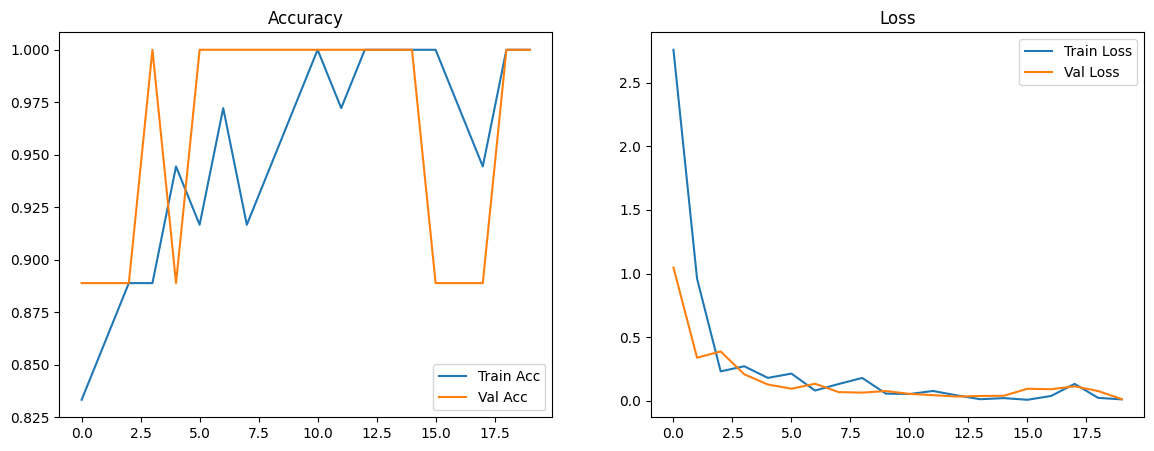

In [35]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()

SINGLE PREDICTION

In [36]:
img = cv2.imread("DATASET/r_101.jpg")
img = cv2.resize(img, (256,256))
img = img / 255.0
img = np.expand_dims(img, axis=0)

prediction = model.predict(img)
print("Probabilitas:", prediction)

class_names = list(train_gen.class_indices.keys())
print("Prediksi kelas:", class_names[np.argmax(prediction)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Probabilitas: [[9.999635e-01 3.646608e-05]]
Prediksi kelas: ANORGANIK
